In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
# Load data
train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# Save test MachineID for submission
test_ids = test['MachineID']

# Prepare features and target
X = train.drop(['MachineID', 'target'], axis=1)
y = train['target']
X_test = test.drop('MachineID', axis=1)

# Convert columns with 'ID' in their names to categorical (object) type
id_cols = [col for col in X.columns if 'ID' in col]
for col in id_cols:
    X[col] = X[col].astype('object')
    X_test[col] = X_test[col].astype('object')

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Preprocessing for numerical and categorical data
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model with balanced class weights
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Create and fit the pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
clf.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
       'HasTpm', 'OSBuildNumber', 'OSProductSuite', 'IsSystemProtected',
       'AutoSampleSubmissionEnabled', 'SMode', 'FirewallEnable...
       'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName',
       'OSInstallType', 'OSInstallLanguageID', 'OSUILocaleID',
       'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing', 'FirmwareManufacturerID', 'FirmwareVersionID', 'DateAS',
       'DateOS'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [2]:
preds = clf.predict_proba(X_test)[:, 1]

# Assuming 'test' is your test dataset and 'predictions' are your model's predictions
submission = pd.DataFrame({'id': range(len(X_test)), 'target': preds})

# Ensure the submission has exactly 10,000 rows
assert len(submission) == 10000, "Submission does not have 10,000 rows"

# Save the submission file
submission.to_csv('/kaggle/working/submission.csv', index=False)


In [3]:
submission = pd.read_csv('/kaggle/working/submission.csv')

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

In [5]:
# Load the data
train_data = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_data = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# Basic data exploration
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Check for missing values
print("Missing values in training data:")
print(train_data.isnull().sum().sum())


Training data shape: (100000, 76)
Test data shape: (10000, 75)
Missing values in training data:
6533


In [6]:
# Separate features and target
X = train_data.drop(['MachineID', 'target'], axis=1)
y = train_data['target']

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
encoders = {}

for col in categorical_cols:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[[col]] = encoder.fit_transform(X[[col]].astype(str))
    test_data[[col]] = encoder.transform(test_data[[col]].astype(str))
    encoders[col] = encoder


In [7]:
# Convert date columns to datetime and extract features
for date_col in ['DateAS', 'DateOS']:
    if date_col in X.columns:
        X[date_col] = pd.to_datetime(X[date_col], errors='coerce')
        X[f'{date_col}_year'] = X[date_col].dt.year
        X[f'{date_col}_month'] = X[date_col].dt.month
        X[f'{date_col}_day'] = X[date_col].dt.day
        
        test_data[date_col] = pd.to_datetime(test_data[date_col], errors='coerce')
        test_data[f'{date_col}_year'] = test_data[date_col].dt.year
        test_data[f'{date_col}_month'] = test_data[date_col].dt.month
        test_data[f'{date_col}_day'] = test_data[date_col].dt.day
        
        # Drop original date columns
        X = X.drop(date_col, axis=1)
        test_data = test_data.drop(date_col, axis=1)

In [8]:
# Handle any remaining missing values
X = X.fillna(-999)
test_data = test_data.fillna(-999)

In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Train a basic Random Forest model
print("Training a basic Random Forest model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

Training a basic Random Forest model...


RandomForestClassifier(random_state=42)

In [11]:
# Make predictions on validation set
y_pred = rf.predict(X_val)
y_pred_proba = rf.predict_proba(X_val)[:, 1]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_val, y_pred_proba)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.61785
ROC AUC: 0.6601355095692443

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      9878
           1       0.62      0.64      0.63     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



In [12]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 important features:")
print(feature_importance.head(10))


Top 10 important features:
                         Feature  Importance
3               SignatureVersion    0.060340
12                        CityID    0.052716
38        SystemVolumeCapacityMB    0.051533
64             FirmwareVersionID    0.049818
32                    OEMModelID    0.047410
35              ProcessorModelID    0.045948
11                     CountryID    0.038514
13                   GeoRegionID    0.033017
42  PrimaryDisplayDiagonalInches    0.032556
14           LocaleEnglishNameID    0.032370



Performing hyperparameter tuning...


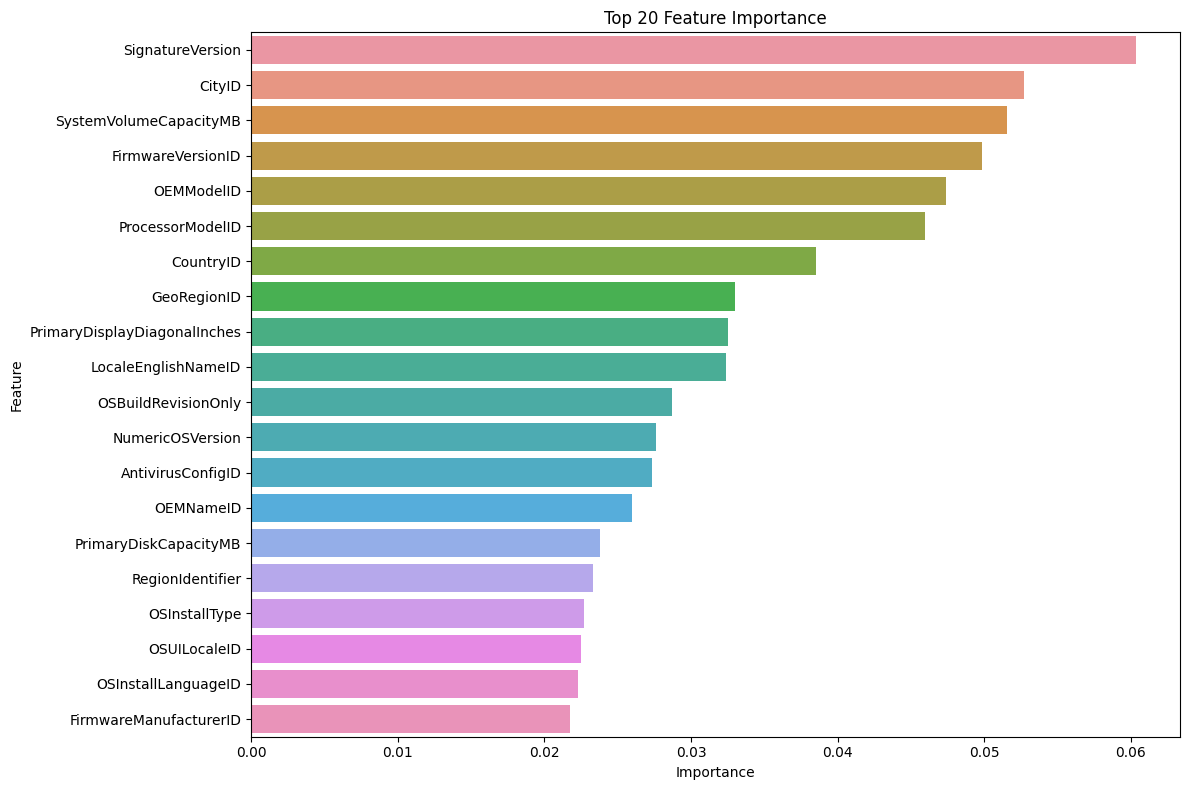

In [13]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

# Hyperparameter tuning with RandomizedSearchCV
print("\nPerforming hyperparameter tuning...")
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

In [14]:
rf_tuned = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(
    rf_tuned, 
    param_distributions=param_dist, 
    n_iter=6, 
    cv=4, 
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)



In [15]:
rand_search.fit(X_train, y_train)

print(f"Best parameters: {rand_search.best_params_}")
print(f"Best ROC AUC score: {rand_search.best_score_}")

Best parameters: {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 314}
Best ROC AUC score: 0.6647594699229636


In [16]:
# Train the model with the best parameters
best_rf = rand_search.best_estimator_

# Make predictions on validation set with tuned model
y_pred_tuned = best_rf.predict(X_val)
y_pred_proba_tuned = best_rf.predict_proba(X_val)[:, 1]

print(f"\nTuned model - Accuracy: {accuracy_score(y_val, y_pred_tuned)}")
print(f"Tuned model - ROC AUC: {roc_auc_score(y_val, y_pred_proba_tuned)}")


Tuned model - Accuracy: 0.62215
Tuned model - ROC AUC: 0.6696893165578766


In [17]:
import os
os.remove("/kaggle/working/submission.csv")

In [18]:
# Make predictions on the test set
test_predictions = best_rf.predict(test_data.drop('MachineID', axis=1))

# Create submission file
submission = pd.DataFrame({
    'id': range(0, 10000),
    'target': test_predictions
})
submission.to_csv("/kaggle/working/submission.csv", index=False)

In [19]:
duplicates = submission[submission.duplicated(['id'], keep=False)]

# Display duplicate rows
print(duplicates)

Empty DataFrame
Columns: [id, target]
Index: []


In [20]:
# Aggregate predictions by taking the mean for duplicate MachineIDs
submission = submission.groupby('id', as_index=False).agg({'target': 'mean'})

# If there are fewer than 10,000 unique MachineIDs after aggregation,
# you will need to add synthetic samples to reach 10,000 rows.
while len(submission) < 10000:
    # Randomly sample from your original predictions to create synthetic entries
    synthetic_samples = submission.sample(n=10000 - len(submission), replace=True)
    synthetic_samples['id'] = [f"SYN_{i}" for i in range(len(synthetic_samples))]
    submission = pd.concat([submission, synthetic_samples], ignore_index=True)

# Ensure the final submission has exactly 10,000 rows
assert len(submission) == 10000, "Submission does not have 10,000 rows"

# Save the final submission file
submission.to_csv('/kaggle/working/submission.csv', index=False)


In [21]:
type(test_ids)

pandas.core.series.Series

In [22]:
duplicates = test_ids[test_ids.duplicated()]

print(duplicates)

2161    f8552815f215d99bd5c0db06e09afb0a
4098    e6ad4443f76b714e048afec17ccff326
Name: MachineID, dtype: object


In [23]:
import pandas as pd
from sklearn.dummy import DummyClassifier

# Load the training and test data
train_data = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_data = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# Separate features and target in training data
X_train = train_data.drop(columns=['MachineID', 'target'])
y_train = train_data['target']

# Extract features from test data
X_test = test_data.drop(columns=['MachineID'])

# Create and train a DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = dummy_clf.predict(X_test)

# Create a submission file with id from 0 to 9999 (assuming test set has 10,000 rows)
submission = pd.DataFrame({
    'id': range(len(X_test)),  # Adjust length based on test set size
    'target': y_pred
})

# If you need it strictly from 0 to 9999 and your test set has 10,000 rows:
# submission['id'] = range(10000)

# Save to CSV
submission.to_csv('/kaggle/working/submission.csv', index=False)


In [24]:
unique_os_versions = train['OSVersion'].nunique()
print(unique_os_versions)

7


Milestone 1

In [25]:
import pandas as pd
train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
print(train['NumAntivirusProductsInstalled'].dropna().max())


5.0


In [26]:
gamer_systems = train[train['IsGamer'] == 1]

# Count systems with malware detected
malware_detected_count = gamer_systems[gamer_systems['target'] == 1].shape[0]

print(f"Number of systems owned by gamers where malware was detected: {malware_detected_count}")

Number of systems owned by gamers where malware was detected: 16294


In [27]:
passive_mode_data = train[train['IsPassiveModeEnabled'] == 1]
most_frequent_value = passive_mode_data['RealTimeProtectionState'].mode().iloc[0]
print(f"Most frequent value of RealTimeProtectionState: {most_frequent_value}")

Most frequent value of RealTimeProtectionState: 0.0


In [28]:
count = train[(train['PrimaryDisplayResolutionHorizontal'] == 1366) & 
                   (train['PrimaryDisplayResolutionVertical'] == 768)].shape[0]

print(f"Number of systems with a screen resolution of 1366 x 768: {count}")

Number of systems with a screen resolution of 1366 x 768: 51435


In [29]:
percentile_50 = train['TotalPhysicalRAMMB'].median()

print(f"The 50th percentile (median) value of TotalPhysicalRAMMB is: {percentile_50}")

The 50th percentile (median) value of TotalPhysicalRAMMB is: 4096.0


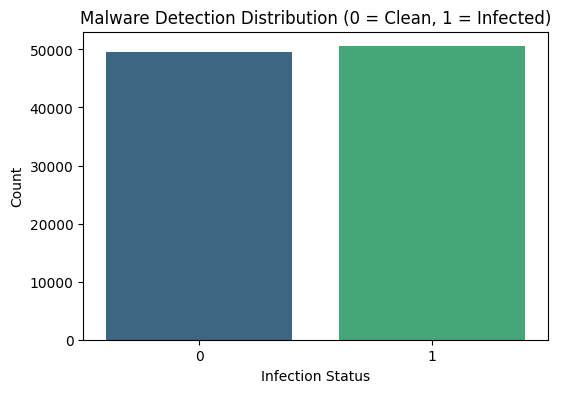

target
1    50.525
0    49.475
Name: proportion, dtype: float64


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
train_data = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')

# Plot target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_data, palette='viridis')
plt.title('Malware Detection Distribution (0 = Clean, 1 = Infected)')
plt.xlabel('Infection Status')
plt.ylabel('Count')
plt.show()

# Calculate percentages
print(train_data['target'].value_counts(normalize=True) * 100)


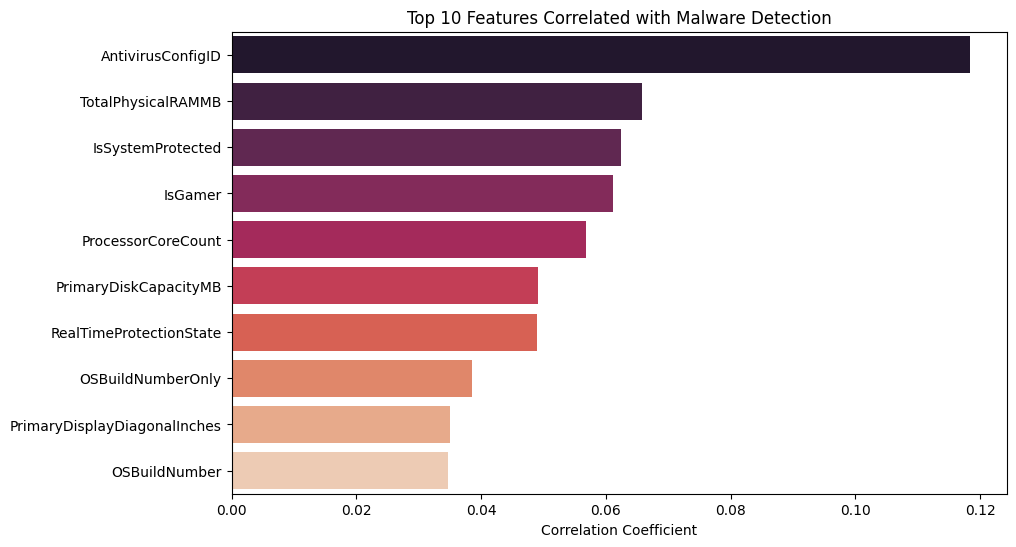

In [31]:
# Calculate correlations with target
corr_with_target = train_data.corr(numeric_only=True)['target'].sort_values(ascending=False)

# Plot top 10 correlations
plt.figure(figsize=(10,6))
sns.barplot(x=corr_with_target[1:11].values, y=corr_with_target[1:11].index, palette='rocket')
plt.title('Top 10 Features Correlated with Malware Detection')
plt.xlabel('Correlation Coefficient')
plt.show()


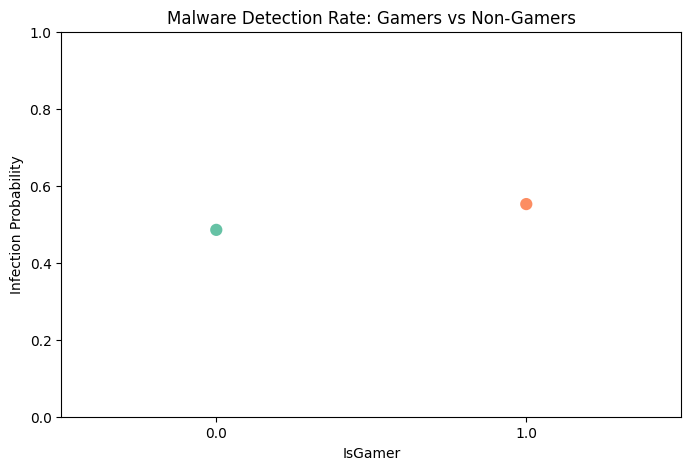

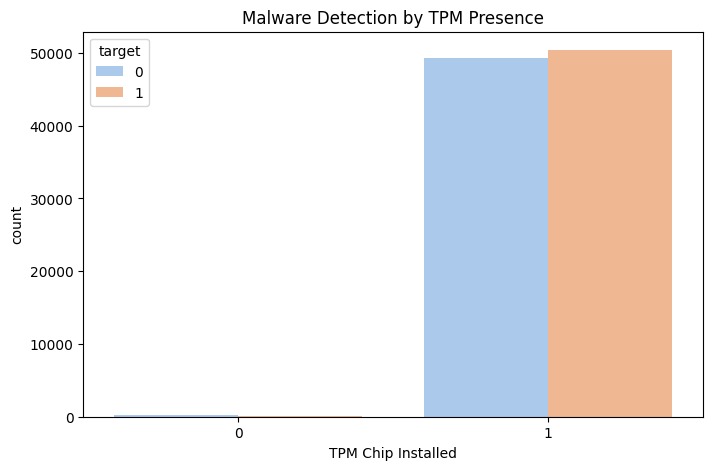

In [32]:
# Plot malware rate by IsGamer status
plt.figure(figsize=(8,5))
sns.pointplot(x='IsGamer', y='target', data=train_data, 
              palette='Set2', errorbar=None)
plt.title('Malware Detection Rate: Gamers vs Non-Gamers')
plt.ylabel('Infection Probability')
plt.ylim(0,1)
plt.show()

# Plot malware rate by TPM presence
plt.figure(figsize=(8,5))
sns.countplot(x='HasTpm', hue='target', data=train_data, palette='pastel')
plt.title('Malware Detection by TPM Presence')
plt.xlabel('TPM Chip Installed')
plt.show()


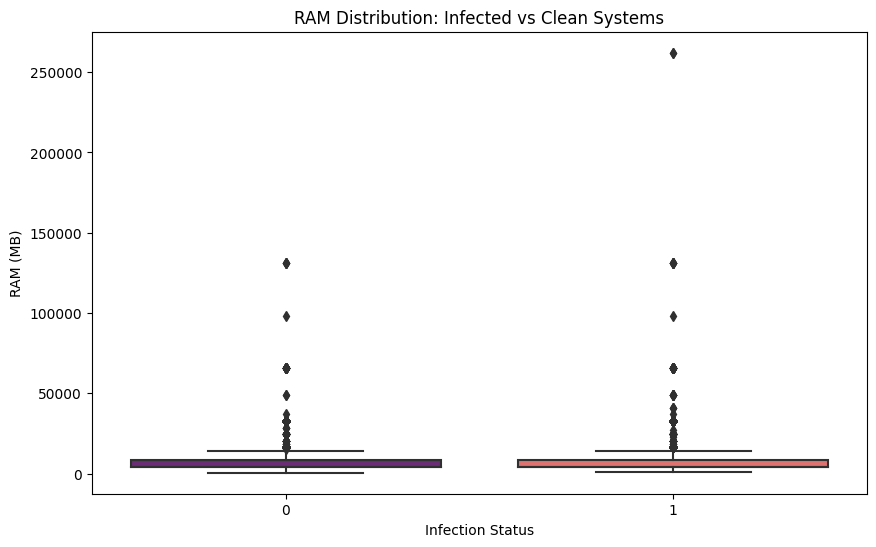

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

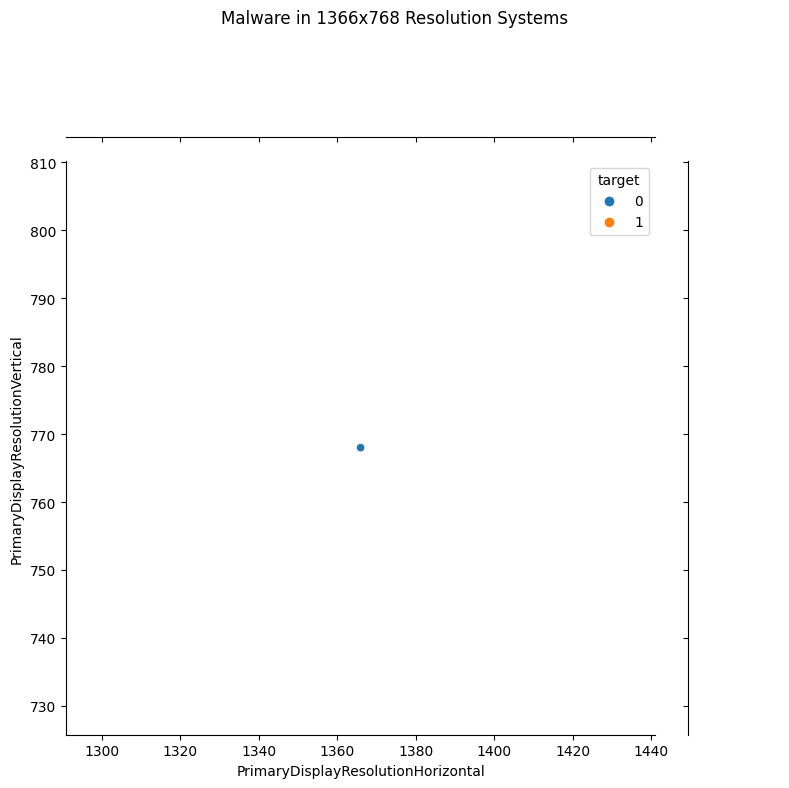

In [33]:
# Compare TotalPhysicalRAMMB distributions
plt.figure(figsize=(10,6))
sns.boxplot(x='target', y='TotalPhysicalRAMMB', data=train_data, palette='magma')
plt.title('RAM Distribution: Infected vs Clean Systems')
plt.xlabel('Infection Status')
plt.ylabel('RAM (MB)')
plt.show()

# Resolution analysis
res_1366x768 = train_data[(train_data['PrimaryDisplayResolutionHorizontal'] == 1366) & 
                          (train_data['PrimaryDisplayResolutionVertical'] == 768)]
sns.jointplot(x='PrimaryDisplayResolutionHorizontal', y='PrimaryDisplayResolutionVertical', 
              data=res_1366x768, hue='target', height=8)
plt.suptitle('Malware in 1366x768 Resolution Systems')
plt.tight_layout()
plt.show()


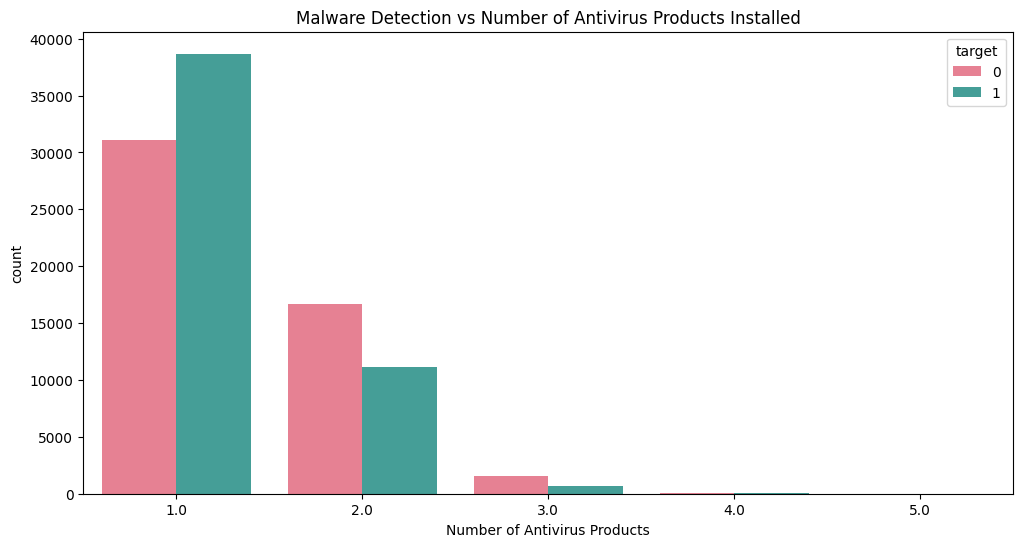

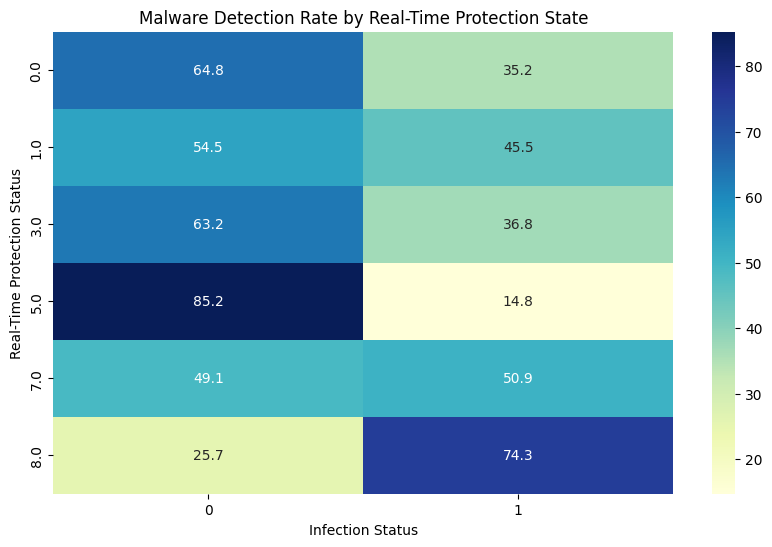

In [34]:
# Antivirus products vs protection
plt.figure(figsize=(12,6))
sns.countplot(x='NumAntivirusProductsInstalled', hue='target', 
              data=train_data, palette='husl')
plt.title('Malware Detection vs Number of Antivirus Products Installed')
plt.xlabel('Number of Antivirus Products')
plt.show()

# Real-time protection effectiveness
cross_tab = pd.crosstab(train_data['RealTimeProtectionState'], train_data['target'], normalize='index')*100
plt.figure(figsize=(10,6))
sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Malware Detection Rate by Real-Time Protection State')
plt.ylabel('Real-Time Protection Status')
plt.xlabel('Infection Status')
plt.show()


Milestone 2

In [35]:

import pandas as pd
df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
df_copy = df.copy()

In [36]:
# Find constant columns
constant_columns = df.nunique()[df.nunique() == 1]
print(constant_columns)

IsBetaUser                     1
AutoSampleSubmissionEnabled    1
IsFlightsDisabled              1
dtype: int64


In [37]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

categorical_cols = df_copy.select_dtypes(include=['object']).columns

encoder = LabelEncoder()
for col in categorical_cols:
    df_copy[col] = encoder.fit_transform(df_copy[col])
corr_matrix = df_copy.corr()
corr_pairs = corr_matrix.abs().unstack()
corr_pairs =corr_pairs[corr_pairs < 1].sort_values(ascending=False)
corr_pairs.head(1)

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


OSEdition  OSSkuFriendlyName    0.998856
dtype: float64

In [38]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

cat_df = df.select_dtypes(include=['object'])
low_cardinality_cols = cat_df.nunique()[cat_df.nunique() <= 10].index

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_cols = encoder.fit_transform(cat_df[low_cardinality_cols])

encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(low_cardinality_cols))

cat_df = cat_df.drop(columns=low_cardinality_cols)
cat_df = pd.concat([cat_df, encoded_df], axis=1)
cat_df.shape[1]

82

In [39]:
from sklearn.preprocessing import MinMaxScaler

num_df = df.select_dtypes(include=['int64', 'float64'])

scaler = MinMaxScaler()
scaled_num_df = pd.DataFrame(scaler.fit_transform(num_df), columns=num_df.columns)
sum_values = scaled_num_df.sum().sum()
print(sum_values)

1585115.729433082


In [40]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

cat_cols = df.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
df[cat_cols] = encoder.fit_transform(df[cat_cols])

X = df.drop(columns=['target'])  # Replace 'target' with the actual target column name
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(X_train, y_train)

y_pred = sgd_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.4951
